# **1. Preparação do ambiente e dos dados **

In [2]:
#importando a libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from io import StringIO
from graphviz import *


In [3]:
#importando os dados
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/Fase 5 - FIAP IA/crop_yield.csv'




Mounted at /content/drive


In [4]:
#tratando dados incorretos o data frame

df = pd.read_csv(file_path)

new_column_names = {
'Crop': 'Cultura',
'Precipitation (mm day-1)': 'Precipitacao',
'Specific Humidity at 2 Meters (g/kg)': 'Umidade_Especifica',
'Relative Humidity at 2 Meters (%)': 'Umidade_Relativa',
'Temperature at 2 Meters (C)': 'Temperatura',
'Yield': 'Rendimento'
}

df = df.rename(columns = new_column_names)

df['Cultura'] = df['Cultura'].str.replace('Oil palm fruit', 'Oil palm, fruit')

print("Verificando a correção nas linhas 40 a 45:")
print(df.iloc[40:45])
print("\n" + "="*50 + "\n")


Verificando a correção nas linhas 40 a 45:
            Cultura  Precipitacao  Umidade_Especifica  Umidade_Relativa  \
40  Oil palm, fruit       1938.42               17.54             82.11   
41  Oil palm, fruit       2301.54               17.81             82.79   
42  Oil palm, fruit       2592.35               17.61             85.07   
43  Oil palm, fruit       2344.72               17.61             84.12   
44  Oil palm, fruit       2339.30               17.70             84.54   

    Temperatura  Rendimento  
40        26.11      201436  
41        26.24      152343  
42        25.56      181826  
43        25.76      178183  
44        25.76      169781  




In [5]:
#redefinindo as colunas
df[['Produto', 'Tipo_Produto']] = df['Cultura'].str.split(', ', n=1, expand=True)

print("DataFrame com as novas colunas 'Produto' e 'Tipo_Produto':")
print(df.head())
print("\n" + "="*50 + "\n")

DataFrame com as novas colunas 'Produto' e 'Tipo_Produto':
        Cultura  Precipitacao  Umidade_Especifica  Umidade_Relativa  \
0  Cocoa, beans       2248.92               17.72             83.40   
1  Cocoa, beans       1938.42               17.54             82.11   
2  Cocoa, beans       2301.54               17.81             82.79   
3  Cocoa, beans       2592.35               17.61             85.07   
4  Cocoa, beans       2344.72               17.61             84.12   

   Temperatura  Rendimento Produto Tipo_Produto  
0        26.01       11560   Cocoa        beans  
1        26.11       11253   Cocoa        beans  
2        26.24        9456   Cocoa        beans  
3        25.56        9321   Cocoa        beans  
4        25.76        8800   Cocoa        beans  




In [6]:
#removendo coluna cultura
df = df.drop('Cultura', axis=1)

#check
print("DataFrame final após a remoção da coluna 'Cultura':")
print(df.head())

DataFrame final após a remoção da coluna 'Cultura':
   Precipitacao  Umidade_Especifica  Umidade_Relativa  Temperatura  \
0       2248.92               17.72             83.40        26.01   
1       1938.42               17.54             82.11        26.11   
2       2301.54               17.81             82.79        26.24   
3       2592.35               17.61             85.07        25.56   
4       2344.72               17.61             84.12        25.76   

   Rendimento Produto Tipo_Produto  
0       11560   Cocoa        beans  
1       11253   Cocoa        beans  
2        9456   Cocoa        beans  
3        9321   Cocoa        beans  
4        8800   Cocoa        beans  


# **Tratamento dos dados**

Nesta etapa, realizamos a importação dos dados e padronização dos campos facilitando analises futuras. No processo, observamos que a coluna cultura poderia ser separada em duas colunas Produto e Tipo_Produto:

- Produto: descreve o produto que está sendo cultivado.
- Tipo_produto: classifica os cultivos em categoria maiores, como "grãos".

Todavia, para realizar isso notamos que faltava uma vírgula em algumas das linhas dos dados e procedemos a correção antes de realizar o "split".


# **2. Analise Exploratória dos dados**

In [7]:
#overview dos dados
print("Informações do DataFrame:")
df.info()

print("Estatísticas descritivas do DataFrame:")
print(df.describe())

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Precipitacao        156 non-null    float64
 1   Umidade_Especifica  156 non-null    float64
 2   Umidade_Relativa    156 non-null    float64
 3   Temperatura         156 non-null    float64
 4   Rendimento          156 non-null    int64  
 5   Produto             156 non-null    object 
 6   Tipo_Produto        156 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 8.7+ KB
Estatísticas descritivas do DataFrame:
       Precipitacao  Umidade_Especifica  Umidade_Relativa  Temperatura  \
count    156.000000          156.000000        156.000000    156.00000   
mean    2486.498974           18.203077         84.737692     26.18359   
std      289.457914            0.293923          0.996226      0.26105   
min     1934.620000           17

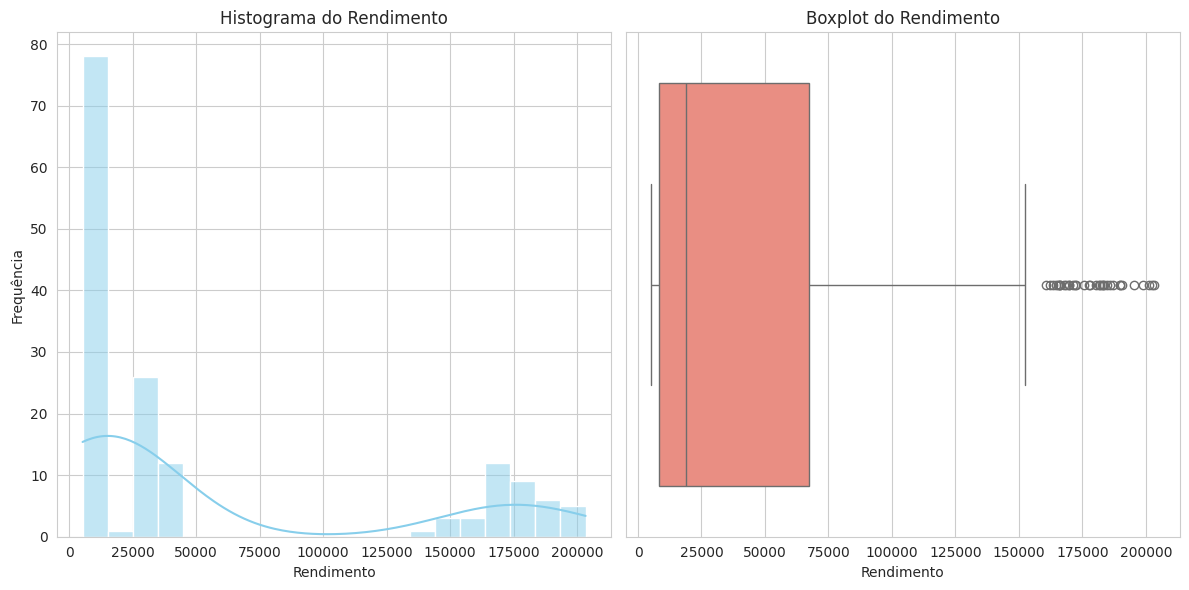

In [8]:
###Entendendo o comportamento da variavel alvo: Rendimento

#histograma
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Rendimento'], bins=20, kde=True, color='skyblue')
plt.title('Histograma do Rendimento')
plt.xlabel('Rendimento')
plt.ylabel('Frequência')

#boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['Rendimento'], color='salmon')
plt.title('Boxplot do Rendimento')
plt.xlabel('Rendimento')

plt.tight_layout()
plt.show()

In [9]:
#Outliers do boxplot

#Intervalo Inter-quartil

q1 = df['Rendimento'].quantile(0.25)
q3 = df['Rendimento'].quantile(0.75)
iqr = q3 - q1

#Limites
lower_bound = q1 - 1.5 * iqr
higher_bound = q3 + 1.5 * iqr

#Contagem de Outliers
outliers = df[(df['Rendimento'] < lower_bound) | (df['Rendimento'] > higher_bound)]
num_outliers = len(outliers)

print(f"Número de outliers: {num_outliers}")

Número de outliers: 35


In [10]:
#Lista de outliers do boxplot
print(outliers.sort_values(by='Rendimento', ascending=False))
print(outliers)


    Precipitacao  Umidade_Especifica  Umidade_Relativa  Temperatura  \
72       2604.59               18.19             83.44        26.43   
73       2308.51               18.27             83.65        26.47   
40       1938.42               17.54             82.11        26.11   
75       2967.41               18.67             85.48        26.46   
66       3085.79               18.34             86.10        26.03   
64       2892.78               18.49             86.09        26.18   
77       2109.34               18.51             83.52        26.72   
76       2333.46               18.50             84.85        26.43   
70       2771.73               18.38             84.98        26.30   
69       2938.29               18.22             85.42        26.06   
63       2363.63               18.35             84.92        26.28   
65       2729.53               18.41             86.03        26.11   
47       2061.61               17.80             84.36        25.88   
67    

In [11]:
#aprofundando Oil Palm

df_oil_palm = df[df['Produto'] == 'Oil palm']
estatisticas_oil_palm = df_oil_palm.describe()

print("Estatísticas Descritivas para 'Oil palm':")
print(estatisticas_oil_palm)

#Comparação isolada com demais produtos
df_sem_oil_palm = df[df['Produto'] != 'Oil palm'].copy()

print("Estatísticas descritivas para todos os produtos, EXCETO 'Oil palm':")
print(df_sem_oil_palm.describe())

Estatísticas Descritivas para 'Oil palm':
       Precipitacao  Umidade_Especifica  Umidade_Relativa  Temperatura  \
count     39.000000           39.000000         39.000000    39.000000   
mean    2486.498974           18.203077         84.737692    26.183590   
std      292.300450            0.296809          1.006009     0.263613   
min     1934.620000           17.540000         82.110000    25.560000   
25%     2305.750000           18.060000         84.175000    26.025000   
50%     2424.550000           18.270000         84.850000    26.130000   
75%     2705.210000           18.390000         85.495000    26.290000   
max     3085.790000           18.700000         86.100000    26.810000   

          Rendimento  
count      39.000000  
mean   175804.692308  
std     14919.869752  
min    142425.000000  
25%    166017.500000  
50%    175629.000000  
75%    185230.000000  
max    203399.000000  
Estatísticas descritivas para todos os produtos, EXCETO 'Oil palm':
       Precipita

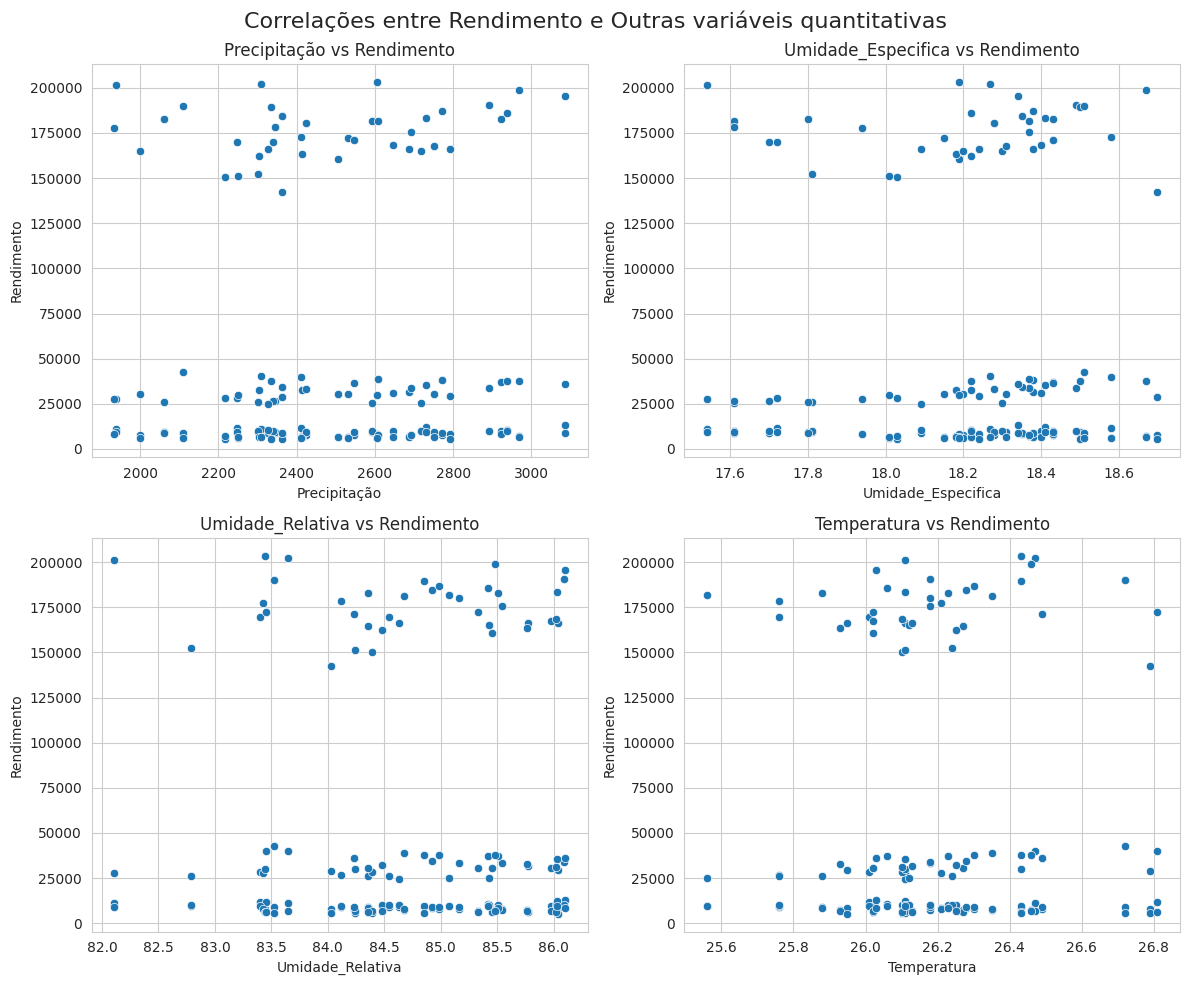

In [12]:
#Entendendo correlações entre rendimento e outras variaveis quantitativas

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Correlações entre Rendimento e Outras variáveis quantitativas', fontsize=16)

# vs Precipitação
sns.scatterplot(x='Precipitacao', y='Rendimento', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Precipitação vs Rendimento')
axes[0, 0].set_xlabel('Precipitação')
axes[0, 0].set_ylabel('Rendimento')

# vs Umidade_Especifica
sns.scatterplot(x='Umidade_Especifica', y='Rendimento', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Umidade_Especifica vs Rendimento')
axes[0, 1].set_xlabel('Umidade_Especifica')
axes[0, 1].set_ylabel('Rendimento')

# vs Umidade_Relativa
sns.scatterplot(x='Umidade_Relativa', y='Rendimento', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Umidade_Relativa vs Rendimento')
axes[1, 0].set_xlabel('Umidade_Relativa')
axes[1, 0].set_ylabel('Rendimento')

# vs Temperatura
sns.scatterplot(x='Temperatura', y='Rendimento', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Temperatura vs Rendimento')
axes[1, 1].set_xlabel('Temperatura')
axes[1, 1].set_ylabel('Rendimento')

plt.tight_layout()
plt.show()

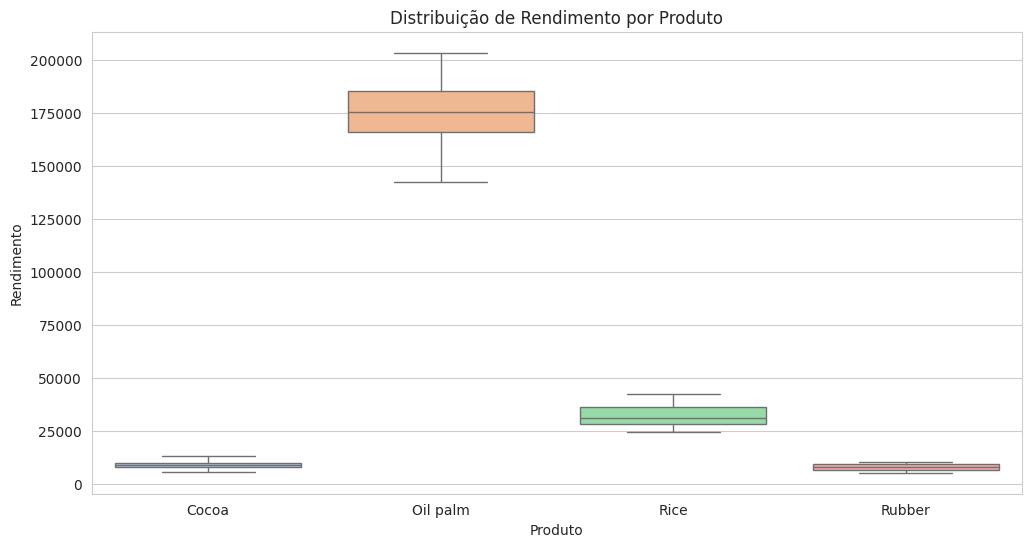

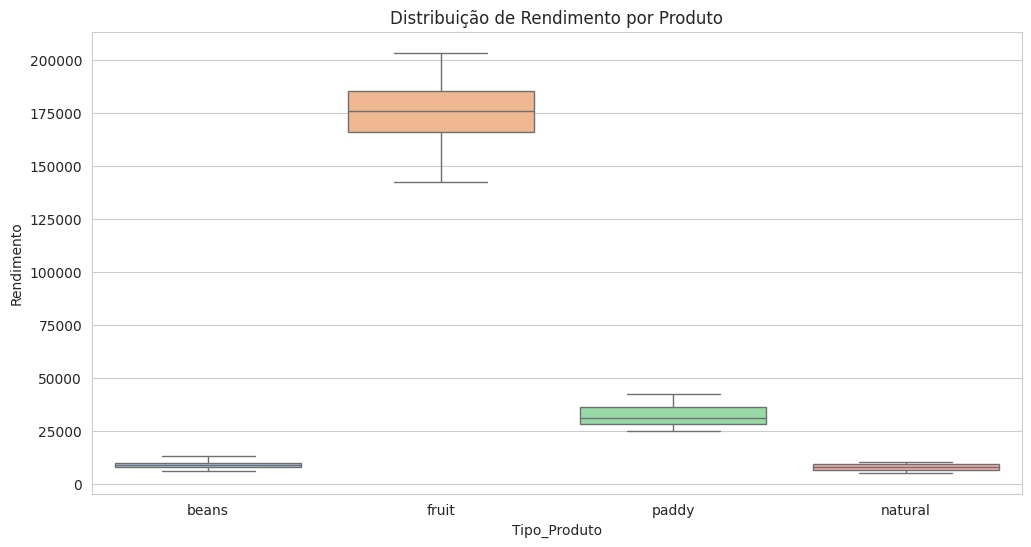

In [13]:
#Entendendo rendimento por produto
plt.figure(figsize=(12, 6))
sns.boxplot(x='Produto', y='Rendimento', data=df, hue = 'Produto', palette='pastel', legend = False)
plt.title('Distribuição de Rendimento por Produto')
plt.xlabel('Produto')
plt.ylabel('Rendimento')
#plt.xticks(rotation=0)
plt.show()

#Entendendo rendimento por tipo produto
plt.figure(figsize=(12, 6))
sns.boxplot(x='Tipo_Produto', y='Rendimento', data=df, hue = 'Tipo_Produto', palette='pastel', legend = False)
plt.title('Distribuição de Rendimento por Produto')
plt.xlabel('Tipo_Produto')
plt.ylabel('Rendimento')
#plt.xticks(rotation=0)
plt.show()


# **Analise explotoratória**

* As estatísticas descritivas mostram condições climáticas estáveis, em especial para Umidade (Especifica e Relativa) e Temperatura. Dado que a medida de amplitude (relativa) não varia mais do que 10% do minimo ao máximo.

* A variação de 60% na amplitude de Precipitação sugere estações chuvosas e secas com características bem marcadas, embora não seja possível aferir isso com bases em dados temporais.

* Observamos que há um grande número de produtos cujo o rendimento está abaixo das 25.000 ton/hec e outro grupo com rendimento superior a 125.000 ton/hec. Observando os boxplots por produto fica claro que o produto de alto rendimento é o Oléo de Palma, enquanto os demais pertencem ao primeiro grupo. Isso também fica evidente ao identificarmos os outliers do boxplot agregado.

* As condições de clima também seguem o mesmo padrão de comportamento dos rendimentos dos grupos citados acima, mas não idenfiticamos visualmente sub-grupos claros com as condições climáticas.

* Concluímos que o produto Oléo de Palma se diferencia dos demais em rendimento, mas a comparação direta das estatísticas descritivas isoladas sugere que não há diferenças climáticas significativas entre os cultivos.


#**3. Clusterização**

In [14]:
#df apenas com métricas

numerical_columns = ['Precipitacao', 'Umidade_Especifica', 'Umidade_Relativa', 'Temperatura']
df_numerical = df[numerical_columns]

#Pré-processamento
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numerical)

print("DataFrame com colunas numéricas escaladas:\n", df_scaled[:5])
print("\n" +"="*50 + "\n")

DataFrame com colunas numéricas escaladas:
 [[-0.82341547 -1.64884495 -1.34708396 -0.66710937]
 [-1.89956502 -2.26322349 -2.64614077 -0.28280708]
 [-0.64104192 -1.34165569 -1.96136664  0.21678591]
 [ 0.36686484 -2.0242985   0.33464075 -2.39646972]
 [-0.49138608 -2.0242985  -0.62202899 -1.62786512]]




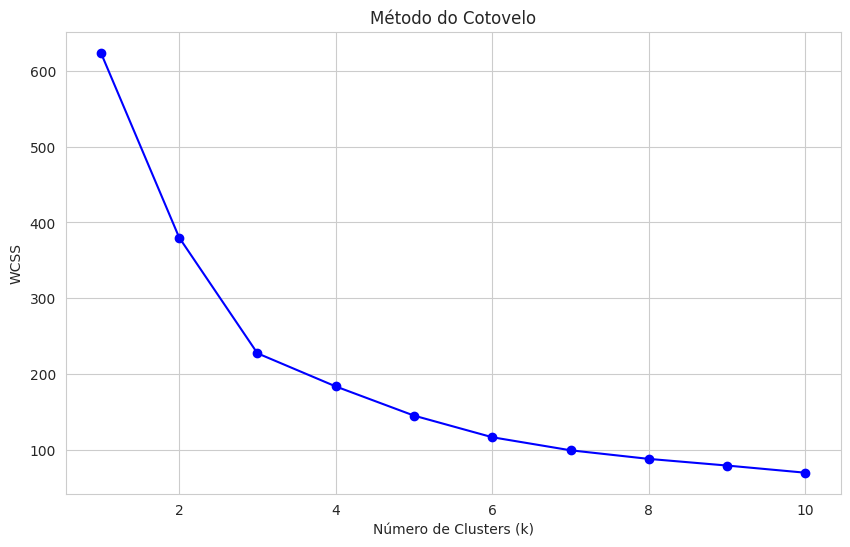

In [15]:
#Método do Cotovelo

wcss = []

k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)


  #Gráfico
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [16]:
#Clusters

##número de clusters
k_ideal = 3

##modelagem
kmeans = KMeans(n_clusters=k_ideal, init='k-means++', max_iter=300, n_init=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

##pts por cluster
print("Distribuição de pontos por cluster:\n")
print(df['Cluster'].value_counts())
print("\n" +"="*50 + "\n")

##analise geral
cluster_analysis = df.groupby('Cluster')[numerical_columns].mean()
print("Análise de cada cluster:\n")
print(cluster_analysis)

##analise por produto
cluster_product_analysis = df.groupby(['Cluster', 'Produto']).agg(lambda x: x.mode()[0])
print("\n Análise de cada cluster por produto:")
print(cluster_product_analysis)


Distribuição de pontos por cluster:

Cluster
0    68
1    44
2    44
Name: count, dtype: int64


Análise de cada cluster:

         Precipitacao  Umidade_Especifica  Umidade_Relativa  Temperatura
Cluster                                                                 
0         2733.517647           18.337647         85.652353    26.118824
1         2232.217273           17.805455         83.916364    25.986364
2         2359.024545           18.392727         84.145455    26.480909

 Análise de cada cluster por produto:
                  Precipitacao  Umidade_Especifica  Umidade_Relativa  \
Cluster Produto                                                        
0       Cocoa          2414.79               18.38             84.98   
        Oil palm       2414.79               18.38             84.98   
        Rice           2414.79               18.38             84.98   
        Rubber         2414.79               18.38             84.98   
1       Cocoa          1934.62           

In [17]:
#Métricas de Avaliação da Clusterização

#Silhouette Score

if len(df['Cluster'].unique()) > 1:
    silhouette_avg = silhouette_score(df_scaled, df['Cluster'])
    print(f"Silhouette Score: {silhouette_avg:.3f}")
else:
    print("Não é possível calcular o Silhouette Score com apenas 1 cluster.")


#Davies-Bouldin Index

davies_bouldin_avg = davies_bouldin_score(df_scaled, df['Cluster'])
print(f"Davies-Bouldin Index: {davies_bouldin_avg:.3f}")



Silhouette Score: 0.435
Davies-Bouldin Index: 0.888


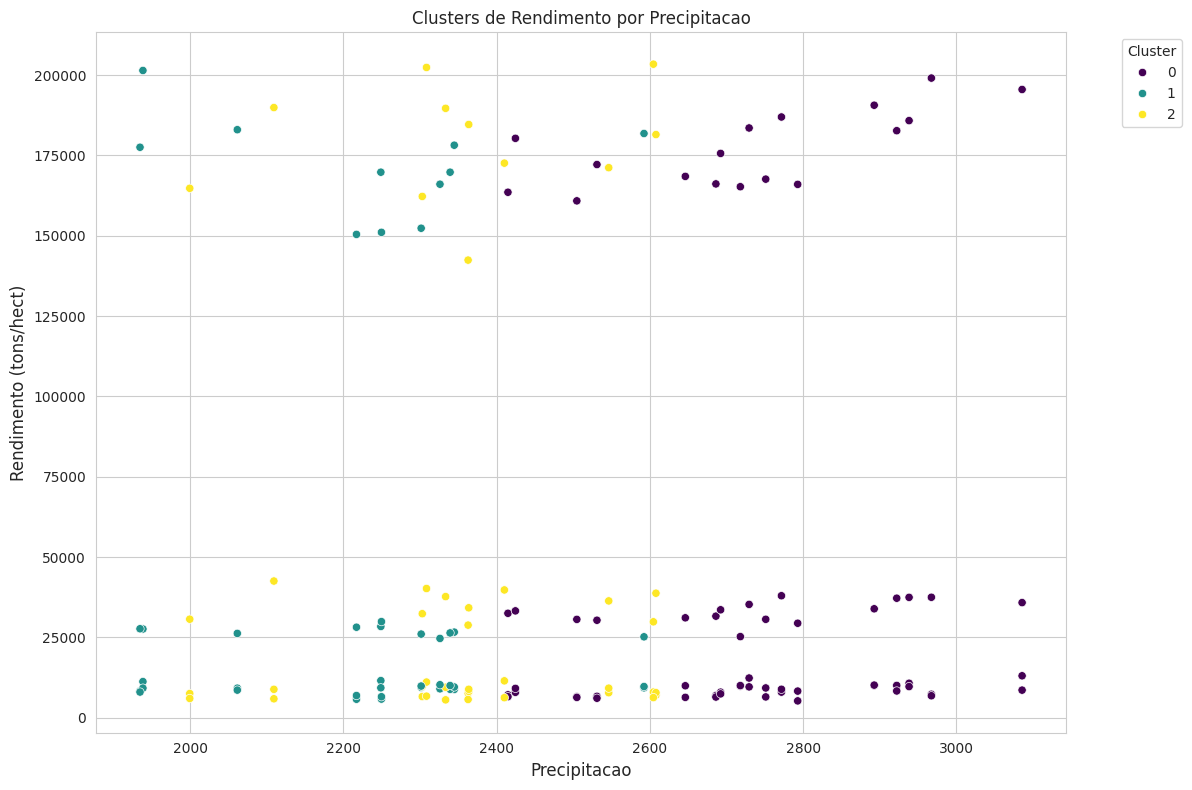

In [18]:
#grafico Clusters

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x = "Precipitacao",
    y = "Rendimento",
    hue = "Cluster",
    data = df,
    palette = "viridis",
    legend = "full"
)

plt.title("Clusters de Rendimento por Precipitacao")
plt.xlabel("Precipitacao", fontsize = 12)
plt.ylabel("Rendimento (tons/hect)", fontsize = 12)
plt.legend(title="Cluster", bbox_to_anchor=(1.05,1) ,loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


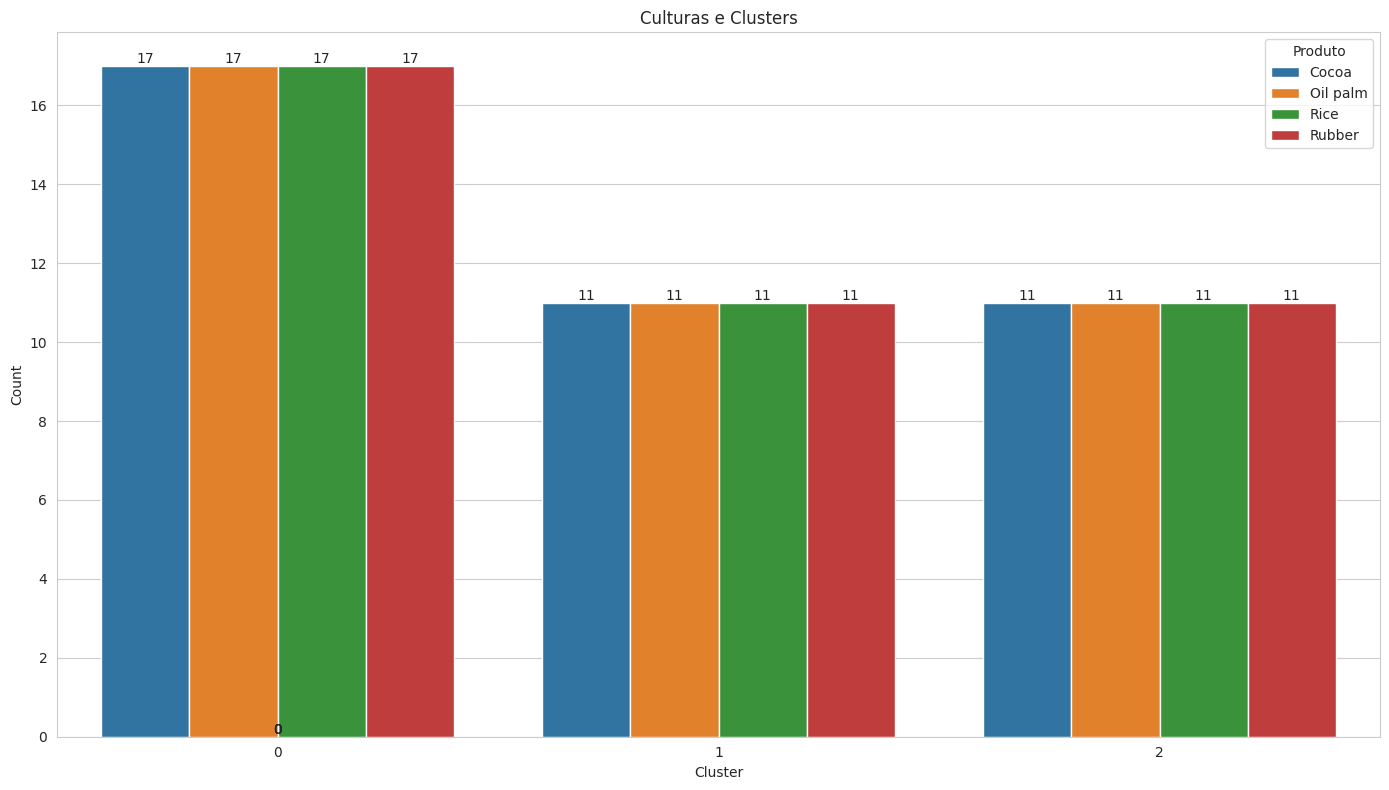

In [19]:
#Culturas e Clusters

df_cluster_product = df.groupby(['Cluster', 'Produto']).size().reset_index(name='Count')

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Cluster', y='Count', hue='Produto', data=df_cluster_product)
plt.title('Culturas e Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Produto')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,  # Posição X do texto (no centro da barra)
        height,                          # Posição Y do texto (no topo da barra)
        f'{int(height)}',                # O texto a ser exibido, formatado como inteiro
        ha='center',                     # Alinhamento horizontal: centralizado
        va='bottom'                      # Alinhamento vertical: na parte de baixo
    )

plt.tight_layout()
plt.show()

In [20]:
#Entendendo os Outliers a partir dos clusters

centroids = kmeans.cluster_centers_

distances = [
    np.linalg.norm(df_scaled[i] - centroids[df['Cluster'][i]])
    for i in range(len(df_scaled))
             ]
df['Distancia_Centroides'] = distances

#outliers

outlier_threshold = df['Distancia_Centroides'].quantile(0.95)

outliers = df[df['Distancia_Centroides'] > outlier_threshold].sort_values(by='Distancia_Centroides', ascending=False)

print("Outliers")
print(outliers)


Outliers
     Precipitacao  Umidade_Especifica  Umidade_Relativa  Temperatura  \
3         2592.35               17.61             85.07        25.56   
42        2592.35               17.61             85.07        25.56   
120       2592.35               17.61             85.07        25.56   
81        2592.35               17.61             85.07        25.56   
40        1938.42               17.54             82.11        26.11   
1         1938.42               17.54             82.11        26.11   
79        1938.42               17.54             82.11        26.11   
118       1938.42               17.54             82.11        26.11   

     Rendimento   Produto Tipo_Produto  Cluster  Distancia_Centroides  
3          9321     Cocoa        beans        1              2.457109  
42       181826  Oil palm        fruit        1              2.457109  
120        9718    Rubber      natural        1              2.457109  
81        25187      Rice        paddy        1       

# **Analise de Clusters - Insights**

* O método do cotovelo sugeriu que o número ideal de Cluster está entre 4 e 6 Clusters. Inicialamente, testamos 5 clusters, mas ao analisar os resultados comparativamente entendemos que 3 clusters seriam para emergir os principais insigths dos dados.

Desta forma, inicialmente optamos pelo construção de 5 clusters distintos, onde:

    * Cluster Verde Ciano (0): baixa precipitação e rendimento
    * Clusters Amarelo (2): sugerem uma região intermediária de cultivo com relação a rendimento e precipitação. Aqui podemos observar a quebra visual mais acentuada entre os grupo de alto rendimento (como visto puxado pelo Oléo de Palma) e os demais produtos.
    * Cluster Azul (1): culturas que possuem rendimento frente a maior precipitação.
  
* A analise dos números sugere que a Precitação foi a variavel com maior distinção entre os clusters para predizer o rendimento, dada que a variação as demais como umidade de temperatura foi menor frente a ela.

* Com relação as métricas de avaliação dos clusters observou-se um desempenho moderado dos indicadores. Entendemos que a opção pela redução do número de cluster garantiu melhor inteligibilidade dos clusters, porém penalizou a diferenciação entre ele (Davies-Bouldin Index), contudo a redução de 5 para 3 cluster aumentou um pouco mais de 1 pp. o Silhouette Score.

          * Silhouette Score: 0.435 - Sugerindo uma coesão razoável entre cluster
          * Davies-Bouldin Index: 0.888 - Sugerindo uma dispersão maior entre clusters.

* Entre os clusters houve uma maior incidencia de produtos nos cluster 0 e 2. A analise outliers a partir dos centroídes sugeriu 8 pontos de outliers.

* Logo, do ponto de vista interpretativo entendemos que os clusters acima apresentou alguns insigths relevantes. Sugerimos que os cluster sejam divididos os subgrupos de alto e baixo rendimento na analise dos agrupamentos dos clusters.

#**4. Predição do rendimento da safra**

In [21]:
#Variaveis preditoras e variável-alvo

X = df.drop('Rendimento', axis=1)
y = df['Rendimento']

#Enconding

categorical_cols = X.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

#Check

print("Dataframe X após o encoding:")
print(X.head())
print("\n" + "="*50 + "\n")


Dataframe X após o encoding:
   Precipitacao  Umidade_Especifica  Umidade_Relativa  Temperatura  Cluster  \
0       2248.92               17.72             83.40        26.01        1   
1       1938.42               17.54             82.11        26.11        1   
2       2301.54               17.81             82.79        26.24        1   
3       2592.35               17.61             85.07        25.56        1   
4       2344.72               17.61             84.12        25.76        1   

   Distancia_Centroides  Produto_Oil palm  Produto_Rice  Produto_Rubber  \
0              0.605859             False         False           False   
1              2.322169             False         False           False   
2              1.514806             False         False           False   
3              2.457109             False         False           False   
4              1.181487             False         False           False   

   Tipo_Produto_fruit  Tipo_Produto_natural  

In [22]:
#Split treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensões de conjunto de treino (X_train): {X_train.shape}")
print(f"Dimensões de conjunto de teste (X_test): {X_test.shape}")


Dimensões de conjunto de treino (X_train): (124, 12)
Dimensões de conjunto de teste (X_test): (32, 12)


In [23]:
#regressão linear simples

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

print("Previsões de rendimento com Regressão Linear Simples:")
print(y_pred_lr)
print("\n" + "="*50 + "\n")

#metricas de avaliação do modelo
r2_lr = r2_score(y_test, y_pred_lr)
print(f"R2 Regressão Linear Simples: {r2_lr}")

mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"MSE Regressão Linear Simples: {mse_lr}")

Previsões de rendimento com Regressão Linear Simples:
[ 31641.33858536 178578.18963873  31266.11537311 174996.26075584
  36913.0310854   11876.36806217  28034.2187223    5626.18476219
  29814.50888287   6648.97440141   8476.29559854  30045.92837186
   6882.39166475   3545.4397412    8277.43800866  11738.58463104
   9142.06120999  29317.82417185  11004.02618558  31325.53615512
  29990.49873369   8709.22136725   7113.81115375   5956.26320107
  11139.75954156  30684.29183714 178715.97306986 171941.70651186
 173953.41616143  31408.41281666 174028.18239077  10482.37772848]


R2 Regressão Linear Simples: 0.9950409399094133
MSE Regressão Linear Simples: 19236053.58904826


In [24]:
#Decision Tree Regression

model_dt= DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train, y_train)

y_pred_dt = model_dt.predict(X_test)

print("Previsões de rendimento com Decision Tree Regression:")

#metricas
r2_dt = r2_score(y_test, y_pred_dt)
print(f"R2 Decision Tree Regression: {r2_dt}")

mse_dt = mean_squared_error(y_test, y_pred_dt)
print(f"MSE Decision Tree Regression: {mse_dt}")


Previsões de rendimento com Decision Tree Regression:
R2 Decision Tree Regression: 0.9928820788187888
MSE Decision Tree Regression: 27610214.59375


In [25]:
#Random Forest

model_rf = RandomForestRegressor(n_estimators=100,random_state=42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

print("Previsões de rendimento com Random Forest:")

#metricas
r2_rf = r2_score(y_test, y_pred_rf)
print(f"R2 Random Forest: {r2_rf}")
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"MSE Random Forest: {mse_rf}")




Previsões de rendimento com Random Forest:
R2 Random Forest: 0.9945119906233091
MSE Random Forest: 21287832.883415643


In [26]:
#Gradient Boosting Regressor

model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,random_state=42)
model_gb.fit(X_train, y_train)

y_pred_gb = model_gb.predict(X_test)

print(f"Previsões de rendimento com Gradient Boosting Regressor:")

r2_gb = r2_score(y_test, y_pred_gb)
print(f"R2 Gradient Boosting Regressor: {r2_gb}")

mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f"MSE Gradient Boosting Regressor: {mse_gb}")

Previsões de rendimento com Gradient Boosting Regressor:
R2 Gradient Boosting Regressor: 0.9937771387685861
MSE Gradient Boosting Regressor: 24138302.407730598


In [27]:
#Support Vector Regressor (SVR)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

##Fit do modelo

model_svr = SVR(kernel='rbf', C=100, gamma="auto")
model_svr.fit(X_train_scaled, y_train_scaled)

y_pred_svr_scaled = model_svr.predict(X_test_scaled)
y_pred_svr = scaler_y.inverse_transform(y_pred_svr_scaled.reshape(-1, 1)).flatten()

print("Previsões de rendimento com SVR:")
print(y_pred_svr)

#metricas
r2_svr = r2_score(y_test, y_pred_svr)
print(f"R2 SVR: {r2_svr}")

mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"MSE SVR: {mse_svr}")


Previsões de rendimento com SVR:
[ 34772.03228719 174742.22452014  28685.07857396 188148.57843258
  46250.23525085  17452.25302626  35465.06353509  20986.00179512
  37461.12766562  10910.18676671  13766.2364425   29253.31611497
  25740.96286498  19460.65888419  12202.31309167  10031.92131022
   4287.09875622  32063.32460943  13805.76248509  35359.70393204
  34445.34916847  14928.20745304  10957.69314206   9269.34584274
   5011.28550219  35058.56642746 197267.87354924 159933.06968766
 166775.55444463  34067.53701097 160624.8764044    8598.33449412]
R2 SVR: 0.9831352423142249
MSE SVR: 65417917.24316515


#5.**Comparação entre modelos**

In [28]:
# Dicionário com os nomes dos modelos e seus respectivos R-quadrado e MSE
model_performance = {
    'Modelo': ['Regressão Linear', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVR'],
    'R-Quadrado': [r2_lr, r2_dt, r2_rf, r2_gb, r2_svr],
    'MSE': [mse_lr, mse_dt, mse_rf, mse_gb, mse_svr]
}

# Criando um DataFrame para facilitar a visualização
df_performance = pd.DataFrame(model_performance)

print("Tabela de Performance dos Modelos:")
print(df_performance)

Tabela de Performance dos Modelos:
              Modelo  R-Quadrado           MSE
0   Regressão Linear    0.995041  1.923605e+07
1      Decision Tree    0.992882  2.761021e+07
2      Random Forest    0.994512  2.128783e+07
3  Gradient Boosting    0.993777  2.413830e+07
4                SVR    0.983135  6.541792e+07


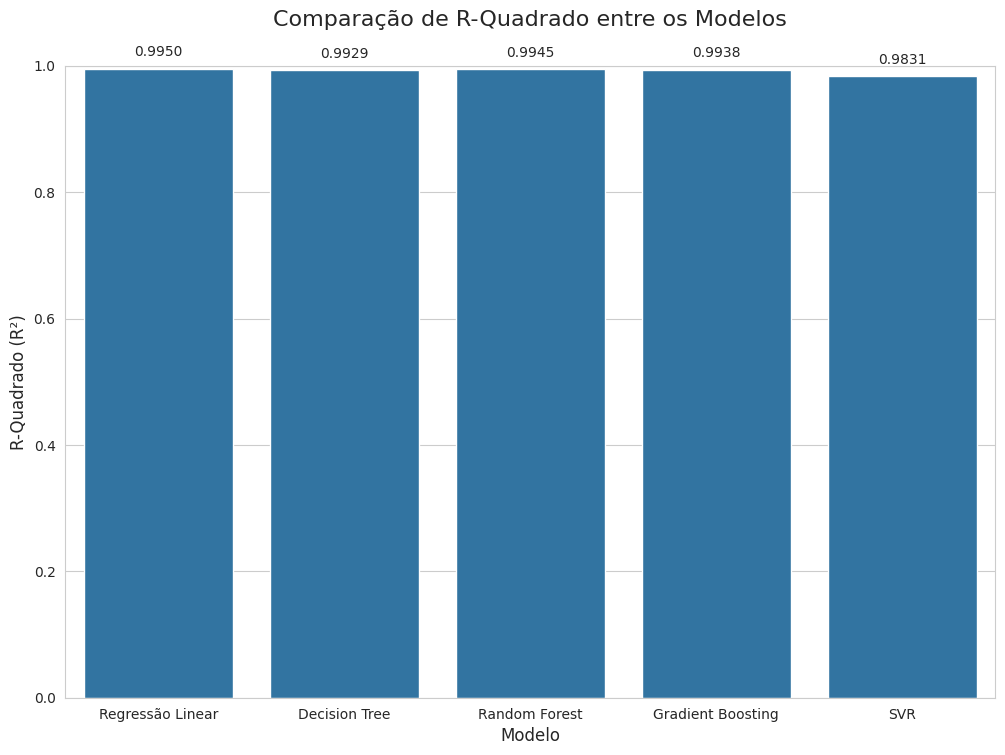

In [29]:
# Gráfico do R-Quadrado
plt.figure(figsize=(12, 8))
sns.barplot(x='Modelo', y='R-Quadrado', data=df_performance)
plt.title('Comparação de R-Quadrado entre os Modelos', fontsize=16, y=1.05)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('R-Quadrado (R²)', fontsize=12)
plt.ylim(0, 1.0) # O R-quadrado varia de 0 a 1
plt.xticks(rotation=0)

# Add valores nas barras
for index, value in enumerate(df_performance['R-Quadrado']):
    plt.text(index, value + 0.02, f'{value:.4f}', ha='center')
plt.subplots_adjust(top=0.9)
plt.show()

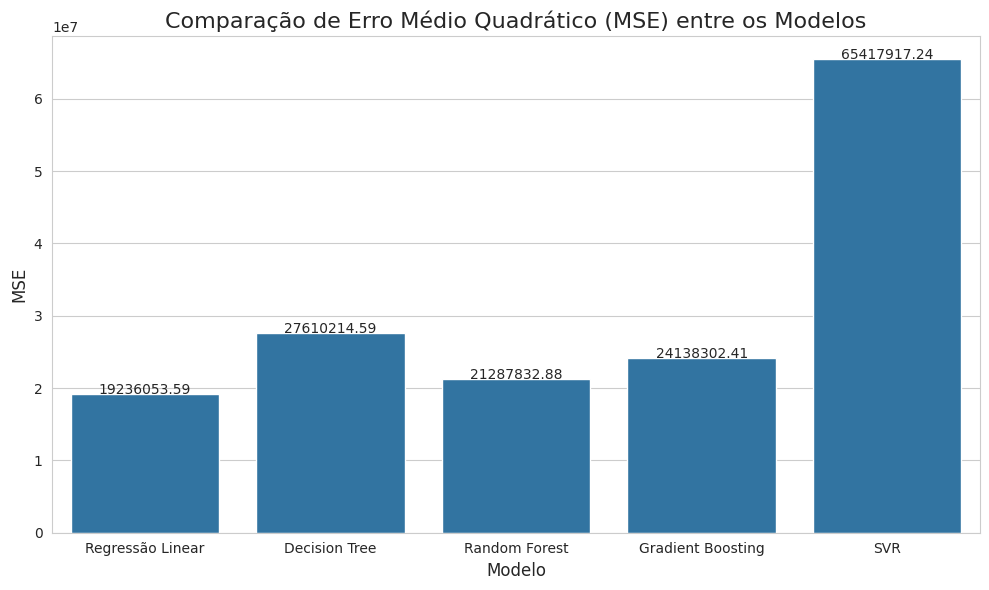

In [30]:
# Gráfico do MSE
plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='MSE', data=df_performance)
plt.title('Comparação de Erro Médio Quadrático (MSE) entre os Modelos', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.xticks(rotation=0)

# Add valores nas barras
for index, value in enumerate(df_performance['MSE']):
    plt.text(index, value + 10, f'{value:.2f}', ha='center')
plt.tight_layout()
plt.show()



In [31]:
#Previsões do Modelo vencedor: Regressão Linear - visão tabela

test_df = df.loc[y_test.index].copy()
test_df['Rendimento Predito'] = y_pred_lr

df_comparacao = test_df.groupby('Produto')[['Rendimento', 'Rendimento Predito']].mean()

print("Tabela de comparação entre Rendimentoo médio Real vs Predito por cultura:")
print(df_comparacao)

Tabela de comparação entre Rendimentoo médio Real vs Predito por cultura:
             Rendimento  Rendimento Predito
Produto                                    
Cocoa       8268.444444         8907.792581
Oil palm  174942.666667       175368.954755
Rice       31434.545455        30949.245885
Rubber      8069.333333         7741.510671


<Figure size 1200x800 with 0 Axes>

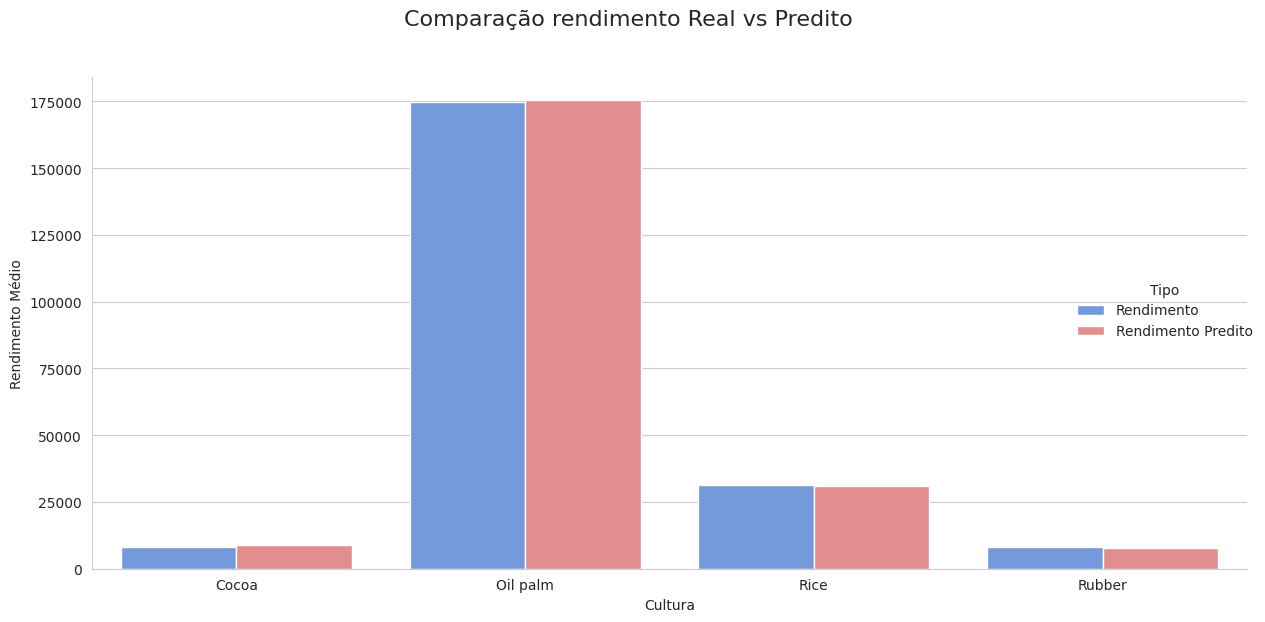

In [32]:
#Previsões do Modelo vencedor: Regressão Linear - gráfico

df_comparacao_reset = df_comparacao.reset_index()

df_long = pd.melt(df_comparacao_reset, id_vars='Produto', var_name='Tipo', value_name='Valor')

sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
g = sns.catplot(x='Produto', y='Valor', hue='Tipo', data=df_long, kind= 'bar', palette=['cornflowerblue', 'lightcoral'], height=6, aspect=1.8)

g.set_axis_labels('Cultura', 'Rendimento Médio')
g.fig.suptitle('Comparação rendimento Real vs Predito', fontsize=16, y=1.03)

plt.tight_layout()
plt.show()

# **Conclusões sobre os modelos**

* A comparação entre o R² e MSE dos modelos sugere que a Random Forest (RF) foi capaz de entregar o maior R² e o menor MSE entre todos os modelos. Contudo, a Regressão Linear (LR) apresentou indicadores muito semelhantes, com diferenças pequenas em relação a ambas as métricas quando comparada a RF.

* Dada a melhor inteligibilidade do LR e menor custo computacional elegemos ela como o modelo vencedor para predição do rendimento da safra.

* Assim, com base nele realizamos uma comparação entre valores preditos e reais e identificamos uma margem de precisão aceitável.